In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json

from sklearn.metrics import adjusted_rand_score
from more_itertools import flatten
from scipy.special import gammaln, digamma
from scipy.stats import gamma

### Function for data extraction

In [96]:
def data_and_param_extract(idx, N_runs):
    ## LOAD RELEVANT DATA
    base_path = "analyses/simulation_studies/simulation_output/simulation_study_3/"

    output_dict = dict()

    ## alpha
    alpha_list = []
    for j in range(N_runs):
        file_path = base_path + f"alpha/alpha_store_{idx}_{j}.pkl"
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        f.close()
        alpha_list.append(data)

    ## beta
    beta_list = []
    for j in range(N_runs):
        file_path = base_path + f"beta/beta_store_{idx}_{j}.pkl"
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        f.close()
        beta_list.append(data)

    ## tau
    tau_list = []
    for j in range(N_runs):
        file_path = base_path + f"tau/tau_store_{idx}_{j}.pkl"
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        f.close()
        tau_list.append(data)

    ## true groups
    groups_in_regions_list = []
    for j in range(N_runs):
        file_path = base_path + f"true_changes/groups_in_regions_{idx}_{j}.pkl"
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        f.close()
        groups_in_regions_list.append(data)


    output_dict['alpha'] = alpha_list
    output_dict['beta'] = beta_list
    output_dict['tau'] = tau_list
    output_dict['groups_in_regions'] = groups_in_regions_list

    ## EXTRACT THE RELEVANT SIMULATION PARAMETERS
    param_path = "analyses/simulation_studies/simulation_parameters/simulation_study_3"
    with open(param_path + '/sim_params_simulation_study_3.json', 'r') as file:
        sim_params = json.load(file)
        sim_params_curr = sim_params[idx]

    output_dict['rate_matrices'] = np.array(sim_params_curr[0])
    output_dict['rho_matrix'] = np.array(sim_params_curr[1])
    output_dict['num_nodes'] = int(sim_params_curr[2])
    output_dict['num_groups'] = int(sim_params_curr[3])
    output_dict['n_cavi'] = int(sim_params_curr[5])
    output_dict['int_length'] = float(sim_params_curr[6])
    output_dict['delta'] = float(sim_params_curr[7])
    output_dict['T_max'] = float(sim_params_curr[8])
    output_dict['new_group_prop'] = float(sim_params_curr[9])

    return output_dict


### Define macros

In [97]:
colours = [(208/255, 28/255, 139/255),
           (241/255, 182/255, 218/255),
           (184/255, 225/255, 134/255),
           (77/255, 172/255, 38/255)]

### Adjusted Rand Index

In [105]:
df_ARI = pd.DataFrame(columns=['delta', 'new_group_prop', 'ARI'], index=range(12))

for sim in range(12):
    data_dict = data_and_param_extract(sim, 50)
    df_ARI.loc[sim, ['delta', 'new_group_prop']] = (
        [data_dict['delta'], data_dict['new_group_prop']]
    )  
    # print(f"New group prop: {data_dict['new_group_prop']}")
    _ARI_list_time = []
    for run in range(50):
        _ARI_list_run = []
        tau_list = data_dict['tau']
        tau_time = tau_list[run]
        # Up to first change
        true_groups = data_dict['groups_in_regions'][run][0]
        for time_step in range(int(2 / 0.1) + 1):
            _group_probs = tau_time[time_step,:,:]
            _pred_groups = _group_probs.argmax(axis=1)
            # if run == 0:
            #     print(f"True groups (pre): {true_groups.mean()}")
            #     print(f"Pred groups (pre): {_pred_groups.mean()}")
            _ARI = adjusted_rand_score(true_groups, _pred_groups)
            _ARI_list_run.append(_ARI)
        
        # Between changes
        true_groups = data_dict['groups_in_regions'][run][1]
        for time_step in range(int(2 / 0.1) + 1, int(3 / 0.1) + 1):
            _group_probs = tau_time[time_step,:,:]
            _pred_groups = _group_probs.argmax(axis=1)
            # if run == 0:
            #     print(f"True groups (between): {true_groups.mean()}")
            #     print(f"Pred groups (between): {_pred_groups.mean()}")
            _ARI = adjusted_rand_score(true_groups, _pred_groups)
            _ARI_list_run.append(_ARI)
            
        # After second change
        true_groups = data_dict['groups_in_regions'][run][2]
        for time_step in range(int(3 / 0.1) + 1, int(5 / 0.1) + 1):
            _group_probs = tau_time[time_step,:,:]
            _pred_groups = _group_probs.argmax(axis=1)
            # if run == 0:
            #     print(f"True groups (post): {true_groups.mean()}")
            #     print(f"Pred groups (post): {_pred_groups.mean()}")
            _ARI = adjusted_rand_score(true_groups, _pred_groups)
            _ARI_list_run.append(_ARI)

        _ARI_list_time.append([l for l in _ARI_list_run])
    df_ARI.loc[sim, 'ARI'] = _ARI_list_time

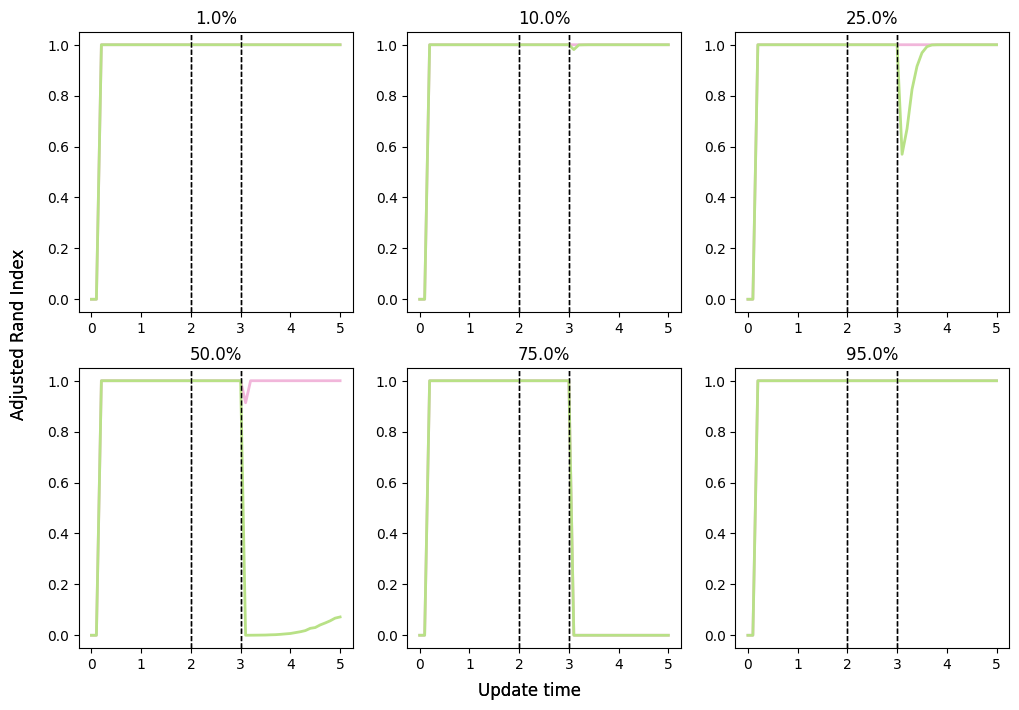

In [106]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

row_counter = -1
group_1_props = [0.01, 0.1, 0.25, 0.5, 0.75, 0.95]
group_1_count = -1
for i in range(2):
    for j in range(3):
        group_1_count += 1
        for delta in [0.1, 1]:
            index = df_ARI[
                        (df_ARI['delta'] == delta)
                        &
                        (df_ARI['new_group_prop'] == group_1_props[group_1_count])
                        ].index[0]
            ARI_data = df_ARI.loc[index, ['ARI']]
            temp_array = np.array([np.array(entry) for entry in ARI_data['ARI']])
            mean_ARI = temp_array.mean(axis=0)
            if delta == 0.1:
                axs[i,j].plot(np.arange(0, 5 + 0.1, 0.1), mean_ARI, color = colours[1],
                              linewidth=2)
                axs[i,j].set_title(fr"{group_1_props[group_1_count] * 100}%", fontsize=12)
            if delta == 1:
                axs[i,j].plot(np.arange(0, 5 + 0.1, 0.1), mean_ARI, color = colours[2],
                              linewidth=2)
                axs[i,j].set_title(fr"{group_1_props[group_1_count] * 100}%", fontsize=12)
            axs[i,j].axvline(x=2, linestyle='--', linewidth=1, color='black')
            axs[i,j].axvline(x=3, linestyle='--', linewidth=1, color='black')

    fig.text(0.5, 0.05, 'Update time', ha='center', fontsize=12)
    fig.text(0.075, 0.4, 'Adjusted Rand Index', ha='center', rotation='vertical', fontsize=12)

plt.savefig("analyses/simulation_studies/simulation_output/simulation_study_3/plots/ARI_time.pdf")

### Posterior rate

In [107]:
df_rates = pd.DataFrame(columns=['delta', 'new_group_prop', 'upper', 'lower', 'mean'], index=range(12))

for sim in range(12):
    data_dict = data_and_param_extract(sim, 50)
    df_rates.loc[sim, ['delta', 'new_group_prop']] = (
        [data_dict['delta'], data_dict['new_group_prop']]
    )  
    alpha_list = data_dict['alpha']; beta_list = data_dict['beta']
    mean_sim = []; upper_sim = []; lower_sim = []
    for run in range(50):
        alpha_run = alpha_list[run]; beta_run = beta_list[run]
        gamma_rv = gamma(a = alpha_run, scale = 1 / beta_run)
        mean_sim.append(gamma_rv.mean())
        upper_sim.append(gamma_rv.ppf(0.975))
        lower_sim.append(gamma_rv.ppf(0.025))
    mean_sim = np.stack(mean_sim).mean(axis=0)
    lower_sim = np.stack(lower_sim).mean(axis=0)
    upper_sim = np.stack(upper_sim).mean(axis=0)

    df_rates.loc[sim, ['upper', 'lower', 'mean']] = [upper_sim, lower_sim, mean_sim]


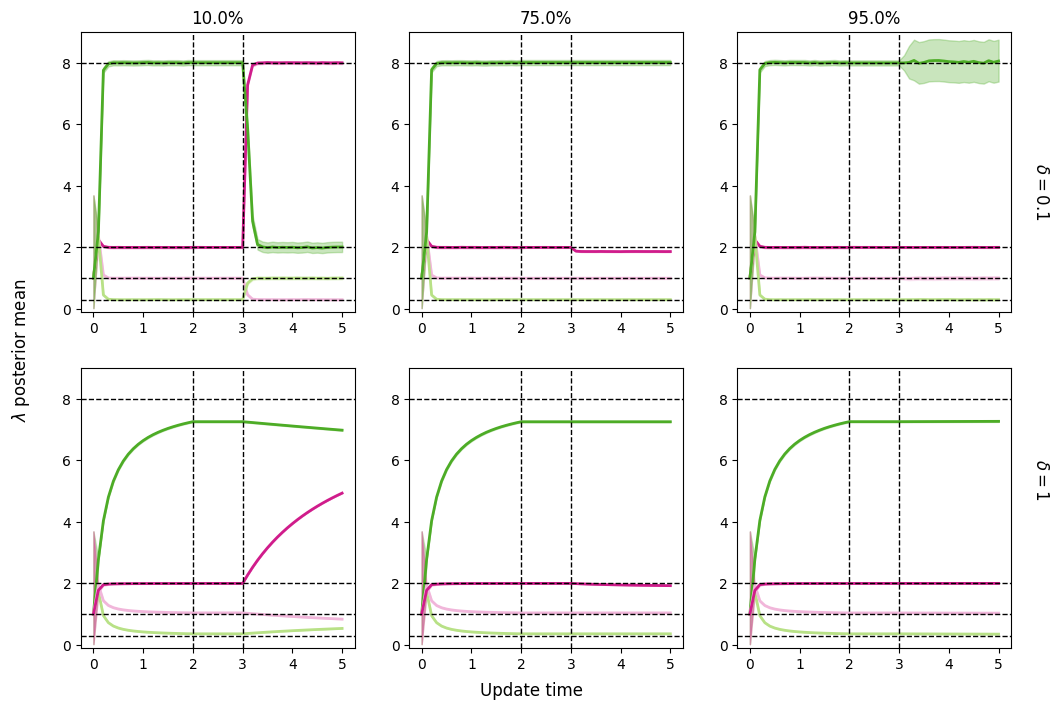

In [112]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

row_counter = -1
group_1_props = [0.1, 0.75, 0.95]
for i, delta in enumerate([0.1, 1]):
    for j in range(3):
        index = df_rates[
                    (df_rates['delta'] == delta)
                    &
                    (df_rates['new_group_prop'] == group_1_props[j])
                    ].index[0]
        mean = df_rates.loc[index, 'mean']
        upper = df_rates.loc[index, 'upper']
        lower = df_rates.loc[index, 'lower']
        if delta == 0.1:
            colour_idx = -1
        else:
            colour_idx = 4
        for k in range(2):
            for m in range(2):
                if delta == 0.1:
                    colour_idx += 1
                else:
                    colour_idx -= 1
                axs[i,j].plot(np.arange(0, 5 + 0.1, 0.1), mean[:,k,m],
                              color = colours[colour_idx], linewidth=2)
                axs[i,j].fill_between(np.arange(0, 5 + 0.1, 0.1), lower[:,k,m], upper[:,k,m],
                                      alpha=0.3, color = colours[colour_idx])
                if i == 0:
                    axs[i,j].set_title(fr"{group_1_props[j] * 100}%", fontsize=12)
        axs[i,j].set_ylim([-0.1, 9])
        for y in [2.0, 1.0, 0.3, 8.0]:
            axs[i,j].axhline(y, linewidth=1, linestyle='--', color='black')
        for x in [2, 3]:
            axs[i,j].axvline(x, linewidth=1, linestyle='--', color='black')
        
    

fig.text(0.5, 0.05, 'Update time', ha='center', fontsize=12)
fig.text(0.075, 0.4, r'$\lambda$ posterior mean', ha='center', rotation='vertical', fontsize=12)
fig.text(0.925, 0.65, r'$\delta = 0.1$', ha='center', rotation=-90, fontsize=12)
fig.text(0.925, 0.3, r'$\delta = 1$', ha='center', rotation=-90, fontsize=12);

plt.savefig("analyses/simulation_studies/simulation_output/simulation_study_3/plots/posterior_means.pdf")

### Group proportions

In [109]:
df_group_prop = pd.DataFrame(columns=['delta', 'new_group_prop', 'pred_group_1_props'], index=range(12))

for sim in range(12):
    data_dict = data_and_param_extract(sim, 50)
    df_group_prop.loc[sim, ['delta', 'new_group_prop']] = (
        [data_dict['delta'], data_dict['new_group_prop']]
    )  
    pred_group_1_prop_sim = []
    for run in range(50):
        tau_list = data_dict['tau']
        pred_group_1_prop_time = tau_list[run].mean(axis=1)[:, 1]
        pred_group_1_prop_sim.append(pred_group_1_prop_time)
    df_group_prop.loc[sim, 'pred_group_1_props'] = np.stack(pred_group_1_prop_sim).mean(axis=0)
    

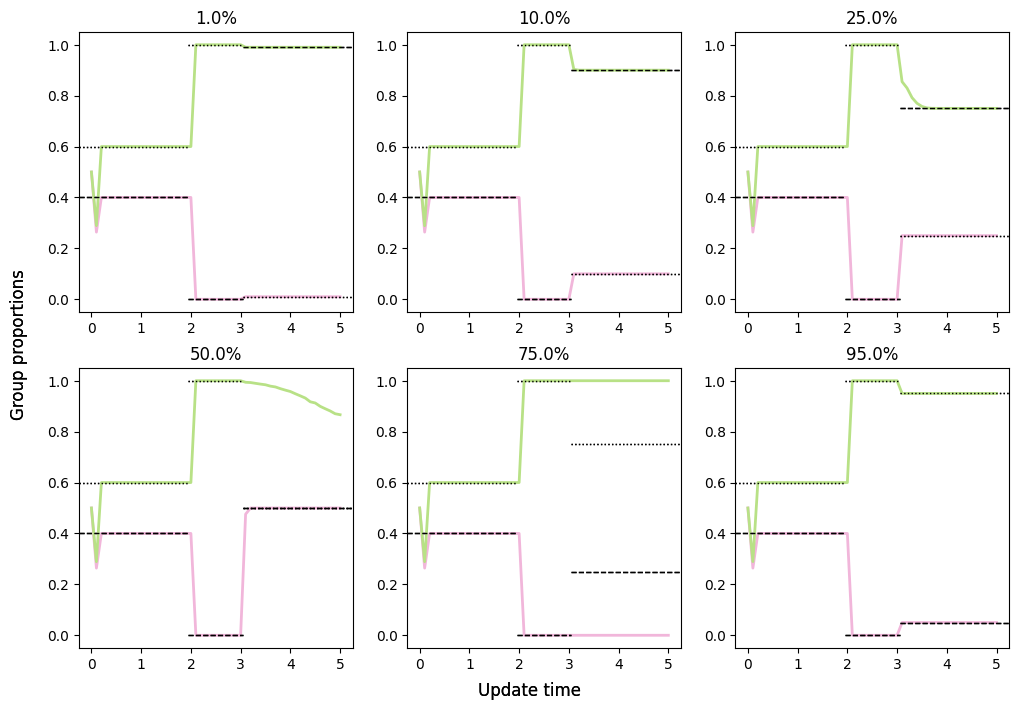

In [110]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

row_counter = -1
group_1_props = [0.01, 0.1, 0.25, 0.5, 0.75, 0.95]
group_1_count = -1
for i in range(2):
    for j in range(3):
        group_1_count += 1
        for delta in [0.1, 1]:
            index = df_group_prop[
                        (df_group_prop['delta'] == delta)
                        &
                        (df_group_prop['new_group_prop'] == group_1_props[group_1_count])
                        ].index[0]
            pred_group_1_props = df_group_prop.loc[index, 'pred_group_1_props']
            if delta == 0.1:
                axs[i,j].plot(np.arange(0, 5 + 0.1, 0.1), pred_group_1_props, 
                              color = colours[1], linewidth=2)
                axs[i,j].set_title(fr"{group_1_props[group_1_count] * 100}%", fontsize=12)
            if delta == 1:
                axs[i,j].plot(np.arange(0, 5 + 0.1, 0.1), pred_group_1_props, 
                              color = colours[2], linewidth=2)
                axs[i,j].set_title(fr"{group_1_props[group_1_count] * 100}%", fontsize=12)
            # axs[i,j].axvline(x=2, linestyle='--', linewidth=1, color='black')
            # axs[i,j].axvline(x=3, linestyle='--', linewidth=1, color='black')

            # Plot true group props
            axs[i,j].axhline(0.4, xmin=0, xmax=2/5,
                             linewidth=1, linestyle='--', color='black');
            axs[i,j].axhline(0, xmin=2/5, xmax=3/5,
                            linewidth=1, linestyle='--', color='black');
            axs[i,j].axhline((1 - group_1_props[group_1_count]), xmin=3/5, xmax=1,
                            linewidth=1, linestyle='--', color='black');
            axs[i,j].axhline(0.6, xmin=0, xmax=2/5,
                            linewidth=1, linestyle='dotted', color='black');
            axs[i,j].axhline(1, xmin=2/5, xmax=3/5,
                            linewidth=1, linestyle='dotted', color='black');
            axs[i,j].axhline((group_1_props[group_1_count]), xmin=3/5, xmax=1,
                            linewidth=1, linestyle='dotted', color='black');

    fig.text(0.5, 0.05, 'Update time', ha='center', fontsize=12)
    fig.text(0.075, 0.4, 'Group proportions', ha='center', rotation='vertical', fontsize=12)

plt.savefig("analyses/simulation_studies/simulation_output/simulation_study_3/plots/group_props.pdf")